## Working with t distributions

The Julia [StatsFuns](https://github.com/JuliaStats/StatsFuns.jl) library includes a number of functions for statistical computing, including functions to evaluate the CDF and PDF for the distribution.  The [Distributions](https://juliastats.org/Distributions.jl/stable/) package provides a higher-level interface, but for our purposes the low-level functions ae probably more appropriate.  Currently, these functions are imported from the R math library.

You will want to add the StatsFuns and Plots packages before running this notebook.

In [1]:
using StatsFuns
using Plots
using QuadGK

ArgumentError: ArgumentError: Package QuadGK not found in current path:
- Run `import Pkg; Pkg.add("QuadGK")` to install the QuadGK package.


In the BTG model with the default prior type (i.e. a flat prior for the variance), the posterior distribution at a point looks like a mixture of t distributions with different scale and location parameters.

Let $f(x; \nu)$ and $F(x; \nu)$ denote the pdf of the standard t distribution with $\nu$ degrees of freedom; these are implemented by the `tdistpdf(nu, x)` and `tdistcdf(nu, x)` functions.  In the BTG setting, we have $\nu = n-p$.  The mean of the standard t is well-defined (and equal to 0) for $\nu > 1$, and the variance is well-defined (and equal to $\nu/(\nu-2)$ for $\nu > 2$.  However, we will frequently prefer other statistics.

We plot the PDF and CDF for a standard t with $\nu = 3$ below.

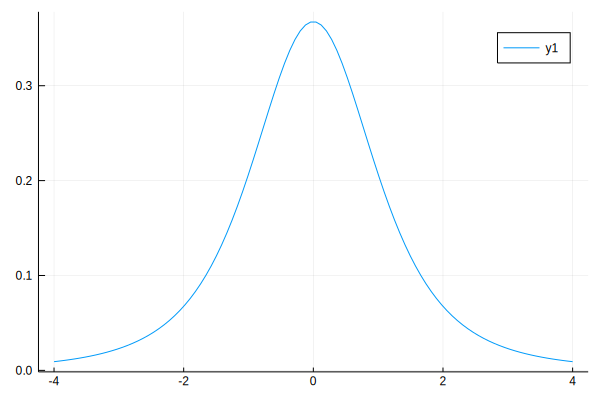

In [2]:
x = range(-4, stop=4, length=100)
fx = tdistpdf.(3, x)
plot(x, fx)

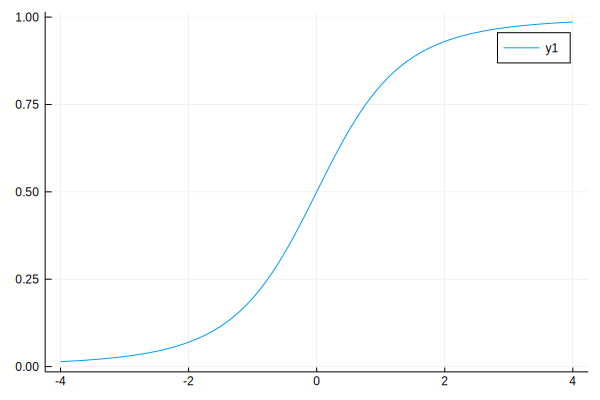

In [3]:
Fx = tdistcdf.(3,x)
plot(x, Fx)

In order to run Newton-type iterations, it is also useful to have the derivative of the PDF.
Recall that the PDF looks like
$$
  f(x; \nu) = C_\nu \left( 1 + \frac{x^2}{\nu} \right)^{-(\nu+1)/2}
$$
where the normalizing constant is
$$
  C_\nu = \frac{\Gamma\left( \frac{\nu+1}{2} \right)}
               {\sqrt{\nu \pi} \Gamma\left( \frac{\nu}{2} \right)}
$$
A little algebra gives us that
$$
  f'(x; \nu) = f(x; \nu) \left[ -\frac{(\nu+1)x}{(\nu+x^2)} \right]
$$
We sanity check our algebra by finite differencing.

In [4]:
xx = rand()
h = 1e-6

# Finite difference estimate
fx = tdistpdf(3, xx)
fxp = tdistpdf(3, xx+h)
fxm = tdistpdf(3, xx-h)
fd_fx = (fxp-fxm)/2/h

# By formula
d_fx = fx*(-4*xx/(3+xx^2))

# Compare
(d_fx-fd_fx)/d_fx

-4.1858312779683203e-11

The generalized t distribution has a location parameter $\hat{\mu}$ and scale parameter $\hat{\sigma}$; variables from this distribution look like $X = \hat{\mu} + \hat{\sigma} T$ where $T$ is a standard t random variable.  In terms of the standard t distribution, the PDF and CDF for the generalized t look like $\hat{\sigma}^{-1} f((x-\hat{\mu})/\hat{\sigma}; \nu)$ and $F((x-\hat{\mu})/\hat{\sigma}; \nu)$, respectively.  The mean and variance for the generalized t are $\mu = \hat{\mu}$ (assuming $\nu > 1$) and $\sigma^2 = \hat{\sigma}^2 \nu/(\nu-2)$ (assuming $\nu > 2$).

Again, a couple plots are useful to illustrate the point (and to sanity check that we got the scaling right).

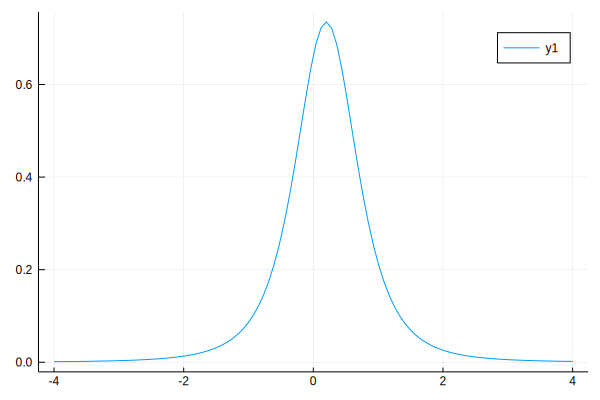

In [5]:
μh = 0.2
σh = 0.5
fx = tdistpdf.(3, (x .- μh)/σh)/σh
plot(x, fx)

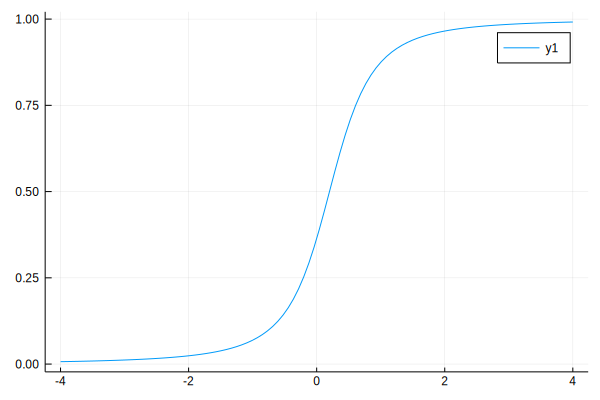

In [6]:
Fx = tdistcdf.(2, (x.-μh)/σh)
plot(x, Fx)

## Mixtures of t distributions

In the BTG method, we have uncertain precision parameters -- integrating that out gives us t distributions -- and
we have uncertain kernel hyper-parameters.  So the prediction at a point, assuming that we have no nonlinearity
looks like
$$
  P(Y(s) = y | \mathrm{data}) = \int_{\theta} P(Y(s) = y | \theta, \mathrm{data}) p(\theta) \, d\theta
$$
In our case, because we already integrated out the precision parameter ($\tau$),
we have that the $Y(s) | \theta, \mathrm{data}$ follows a t distribution with
a fixed scale parameter (depending on $\theta$) and location parameter (depending on $\theta$), i.e.
$Y(s) | \theta, \mathrm{data}$ is a generalized t with location parameter $\hat{\mu}(s; \theta) = k_{sS}(\theta) K_{SS}(\theta)^{-1} y_S$
and scale parameter $\hat{\sigma}^2(s; \theta) = \tau^{-1} (k_{ss}(\theta) - k_{sS}(\theta) K_{SS}(\theta)^{-1} k_{Ss}(\theta))$

In general, we can't compute the integrals exactly, so we use a quadrature rule, i.e.
$$
  P(Y(s) = y | \mathrm{data}) \approx \sum_{j=1}^m w_j P(Y(s) = y | \theta_j, \mathrm{data})
$$
For example, if $p(\theta) = 1$ on $[a,b]$ and $0$ elsewhere, the quadrature rule might be the Gauss-Legendre
quadrature on that interval.

Hence, the BTG posterior distributions in general are (infinite) mixtures of t distributions, 
all with the same $\nu$, but with and different scale and location parameters.
We approximate these with finite mixtures, for which the PDF and CDF are by
\begin{align*}
  g(x) &= \sum_{j=1}^m w_j \hat{\sigma}_j^{-1} f((x-\hat{\mu}_j)/\hat{\sigma_j}; \nu) \\
  G(x) &= \sum_{j=1}^m w_j F((x-\hat{\mu}_j)/\hat{\sigma}_j; \nu)
\end{align*}
where the weights $w_j$ should be non-negative and sum to 1.  We define a convenience
function to instantiate the PDF and CDF functions for a given set of weights and
location and scale parameters.

In [7]:
function tmixture_pdf_and_cdf(ν, ws, μhs, σhs)
    g(x) = ws' * (tdistpdf.(ν, (x .- μhs)./σhs)./σhs)
    G(x) = ws' * tdistcdf.(ν, (x .- μhs)./σhs)
    return g, G
end

tmixture_pdf_and_cdf (generic function with 1 method)

It is again useful to plot an example of such a distribution.

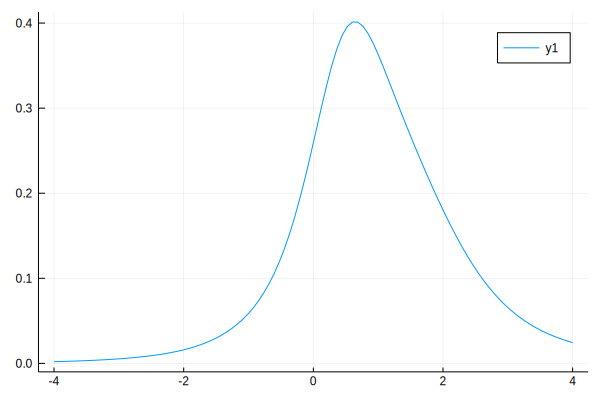

In [8]:
ws = [0.2; 0.6; 0.2]
μhs = [0.5; 1.0; 1.5]
σhs = [0.5; 1; 2]
ν = 10
g, G = tmixture_pdf_and_cdf(ν, ws, μhs, σhs)
plot(x, g.(x))

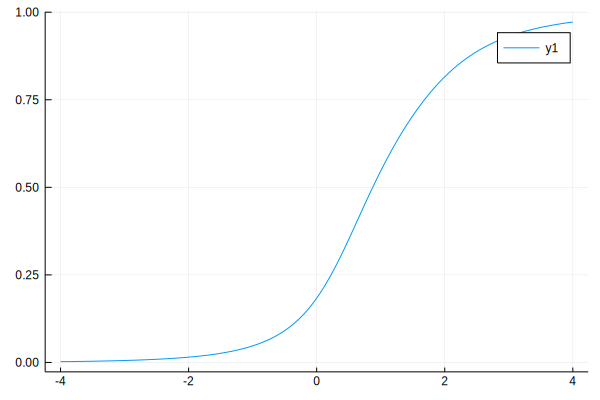

In [9]:
plot(x, G.(x))

The moments of the weighted combination of t distributions is the same as the weighted combination of the corresponding moments, i.e. if $X$ is a draw from the mixed distribution, then
\begin{align*}
  E[X]   &= \sum_j w_j \hat{\mu}_j \\
  E[X^2] &= \sum_j w_j \left( \frac{\nu \hat{\sigma}_j^2}{\nu-2} + \hat{\mu}_j^2 \right)
\end{align*}
It is again useful to sanity check.

In [10]:
xbar, err = quadgk(x -> g(x)*x,   -1e4, 1e4)
x2bar,err = quadgk(x -> g(x)*x^2, -1e4, 1e4)
xbar_ref = ws' * μhs
x2bar_ref = ws' * (ν/(ν-2)*σhs.^2 + μhs.^2)

print("Relerr for computed mean: $((xbar - xbar_ref)/xbar)\n")
print("Relerr for second moment: $((x2bar- x2bar_ref)/x2bar)\n")

UndefVarError: UndefVarError: quadgk not defined

The mean of the weighted distribution is thus pretty easy to compute, and the variance is given by

In [11]:
tmixture_variance(ν, ws, μhs, σhs) = ws' * (ν/(ν-2) * σhs.^2 + μhs.^2) - (ws' * μhs)^2

var_ref = tmixture_variance(ν, ws, μhs, σhs)
var_quad = x2bar - xbar^2
(var_ref-var_quad)/var_ref

UndefVarError: UndefVarError: xbar not defined

We can get a crude estimate of quantiles of the mixed distribution in terms of a generalized t distribution that matches the mean and variance.

In [12]:
σ_mix = sqrt(var_ref*(ν-2)/ν)
quantile75_mix = σ_mix * tdistinvcdf(ν, 0.75) + xbar_ref
quantile25_mix = σ_mix * tdistinvcdf(ν, 0.25) + xbar_ref

plot(x, G.(x), linewidth=3, label="True CDF")
plot!(x, tdistcdf.(ν, (x.-xbar_ref)./σ_mix ), label="Approximate CDF")
plot!([quantile25_mix; quantile25_mix], [0; 1], label="Approximate 25%")
plot!([quantile75_mix; quantile75_mix], [0; 1], label="Approximate 75%")

UndefVarError: UndefVarError: xbar_ref not defined

Once we have an estimate for the quantiles, we can refine the estimate by a few steps of Newton.

In [13]:
function tmixture_quantile(ν, ws, μhs, σhs, q)
    g, G = tmixture_pdf_and_cdf(ν, ws, μhs, σhs)
    σh_mix = sqrt(tmixture_variance(ν, ws, μhs, σhs) * (ν-2)/ν)
    μh_mix = ws' * μhs
    x = σ_mix * tdistinvcdf(ν, q) + xbar_ref
    for j = 1:10
        dx = (G(x)-q)/g(x)
        x -= dx
        if abs(dx) <= 1e-8*abs(x)
            break
        end
    end
    return x
end

G(tmixture_quantile(ν, ws, μhs, σhs, 0.75))-0.75

UndefVarError: UndefVarError: xbar_ref not defined

Note that if we want lower or upper bounds on a quantile of $G$, we can look at the collection of quantiles
for all of the component distributions.  That is, let $G_j(x) = F((x-\mu_j)/\sigma_j)$ so that
$$
  G(x) = \sum_{j=1}^m w_j G_j(x).
$$
Then $G_j(x) \leq p$ for all $j$ implies $G(x) \leq p$; and $G_j(x) \geq p$ for all $j$ implies $G(x) \geq p$.
The implication is that if $G_j(\hat{x}_j) = p$ for each $\hat{x}_j$, then $G(\hat{x}) = p$ means $\min_j \hat{x}_j \leq \hat{x} \leq \max_j \hat{x}_j$.

In [14]:
q = 0.75
w = tdistinvcdf(ν, q)
xhs = σhs * w + μhs
xh = tmixture_quantile(ν, ws, μhs, σhs, q)
println("xh = $xh")
println("xhs = $xhs")

UndefVarError: UndefVarError: xbar_ref not defined